In [1]:

import pandas as pd
import numpy as np
import json
import glob
from pathlib import Path
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt


In [2]:

# Path to labeled JSON files
json_dir = "./data"  # <-- CHANGE THIS
all_files = glob.glob(str(Path(json_dir) / "*.json"))

records = []
for fpath in all_files:
    with open(fpath, 'r') as f:
        try:
            data = json.load(f)
            if isinstance(data, list):
                records.extend(data)
            else:
                records.append(data)
        except json.JSONDecodeError:
            continue

df = pd.DataFrame(records)
df["timestamp"] = pd.to_datetime(df["timestamp"], errors='coerce')
df = df.dropna(subset=["timestamp"])
df = df.sort_values("timestamp")
df.set_index("timestamp", inplace=True)
df.head()

,type,collector_ip,peer_asn,prefix,as_path,origin,label
timestamp,,,,,,,
2004-12-23 09:20:03+00:00,withdrawal,192.65.185.144,6893,3,[2],None,0.0
2004-12-23 09:20:06+00:00,withdrawal,192.65.185.144,6893,2,[3],None,0.0
2004-12-23 09:20:12+00:00,announcement,192.65.185.142,20932,196.204.0.0/16,"[20932, 15412, 24835, 24835, 24835, 24835]",IGP,0.0
2004-12-23 09:20:12+00:00,announcement,192.65.185.142,20932,66.251.16.0/24,"[20932, 174, 13407, 32802]",IGP,0.0
2004-12-23 09:20:12+00:00,announcement,192.65.185.142,20932,202.179.152.0/24,"[20932, 3549, 3356, 15412]",IGP,0.0


In [3]:
df["label"].value_counts()

label
1.0    95519
0.0    88961
Name: count, dtype: int64

In [4]:

feature_rows = []
labels = []
windowed = df.groupby(pd.Grouper(freq="0.5Min"))

for window_start, group in windowed:
    if len(group) == 0:
        continue

    announcements = (group["type"] == "announcement").sum()
    withdrawals = (group["type"] == "withdrawal").sum()
    unique_prefixes = group["prefix"].nunique()
    unique_peers = group["peer_asn"].nunique()
    unique_origins = group["origin"].nunique()
    mean_as_path_len = group["as_path"].dropna().apply(len).mean() if "as_path" in group else 0
    mean_interarrival = group.index.to_series().diff().dropna().dt.total_seconds().mean()

    # Majority vote for label in window
    window_labels = group["label"].dropna().astype(int)
    label = 1 if (window_labels.sum() / len(window_labels)) > 0.5 else 0

    feature_rows.append({
        "window_start": window_start,
        "announcements": announcements,
        "withdrawals": withdrawals,
        "unique_prefixes": unique_prefixes,
        "unique_peer_asns": unique_peers,
        "unique_origins": unique_origins,
        "avg_as_path_len": mean_as_path_len or 0,
        "mean_interarrival": mean_interarrival or 0
    })
    labels.append(label)

features_df = pd.DataFrame(feature_rows).fillna(0)
features_df["label"] = labels
features_df.set_index("window_start", inplace=True)
features_df.head()


C:\Users\chery\AppData\Local\Temp\ipykernel_8212\2736890218.py:19: RuntimeWarning: invalid value encountered in scalar divide
  label = 1 if (window_labels.sum() / len(window_labels)) > 0.5 else 0
C:\Users\chery\AppData\Local\Temp\ipykernel_8212\2736890218.py:19: RuntimeWarning: invalid value encountered in scalar divide
  label = 1 if (window_labels.sum() / len(window_labels)) > 0.5 else 0
C:\Users\chery\AppData\Local\Temp\ipykernel_8212\2736890218.py:19: RuntimeWarning: invalid value encountered in scalar divide
  label = 1 if (window_labels.sum() / len(window_labels)) > 0.5 else 0
C:\Users\chery\AppData\Local\Temp\ipykernel_8212\2736890218.py:19: RuntimeWarning: invalid value encountered in scalar divide
  label = 1 if (window_labels.sum() / len(window_labels)) > 0.5 else 0
C:\Users\chery\AppData\Local\Temp\ipykernel_8212\2736890218.py:19: RuntimeWarning: invalid value encountered in scalar divide
  label = 1 if (window_labels.sum() / len(window_labels)) > 0.5 else 0
C:\Users\chery\

,announcements,withdrawals,unique_prefixes,unique_peer_asns,unique_origins,avg_as_path_len,mean_interarrival,label
window_start,,,,,,,,
2004-12-23 09:20:00+00:00,43,2,35,4,2,4.866667,0.568182,0
2004-12-23 09:20:30+00:00,140,0,125,3,1,5.250000,0.100719,0
2004-12-23 09:21:00+00:00,218,2,144,4,2,5.113636,0.073059,0
2004-12-23 09:21:30+00:00,105,0,98,3,2,4.961905,0.153846,0
2004-12-23 09:22:00+00:00,32,2,33,4,1,5.676471,0.454545,0


In [5]:
features_df["label"].value_counts()

label
0    63
1    31
Name: count, dtype: int64

In [18]:

X = features_df.drop(columns=["label"])
y = features_df["label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

clf = SVC(kernel='linear')


In [24]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid to search
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100, 1000],
    'gamma': ['scale', 'auto', 1, 0.1, 0.01, 0.001],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'] 
}

grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='f1', verbose=1)

# Fit grid search on training data
grid_search.fit(X_train_scaled, y_train)

# Best estimator from grid
clf = grid_search.best_estimator_
print(grid_search.best_estimator_)

# Predict and evaluate
y_pred = clf.predict(X_test_scaled)


Fitting 5 folds for each of 144 candidates, totalling 720 fits
SVC(C=100, degree=2, kernel='linear')


Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.92      0.83        13
           1       0.67      0.33      0.44         6

    accuracy                           0.74        19
   macro avg       0.71      0.63      0.64        19
weighted avg       0.72      0.74      0.71        19

Confusion Matrix:
[[12  1]
 [ 4  2]]


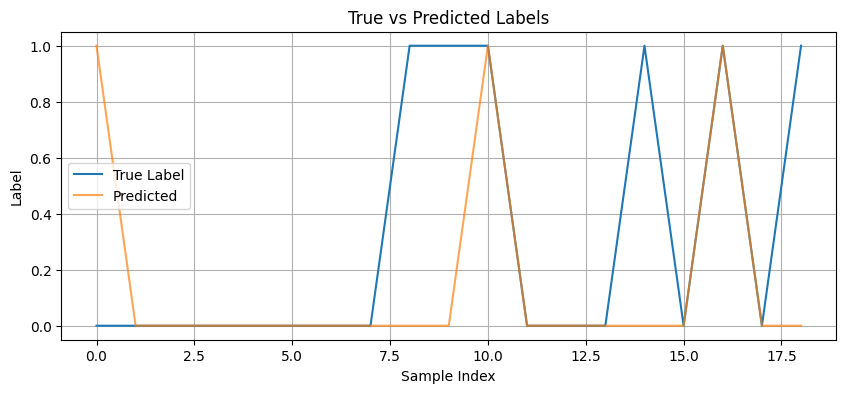

In [25]:

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

plt.figure(figsize=(10, 4))
plt.plot(y_test.reset_index(drop=True), label='True Label')
plt.plot(y_pred, label='Predicted', alpha=0.7)
plt.legend()
plt.title("True vs Predicted Labels")
plt.xlabel("Sample Index")
plt.ylabel("Label")
plt.grid(True)
plt.show()


In [ ]:
feature_rows = []
labels = []
windowed = df.groupby(pd.Grouper(freq="0.25Min"))

for window_start, group in windowed:
    if len(group) == 0:
        continue

    announcements = (group["type"] == "announcement").sum()
    withdrawals = (group["type"] == "withdrawal").sum()
    unique_prefixes = group["prefix"].nunique()
    unique_peers = group["peer_asn"].nunique()
    unique_origins = group["origin"].nunique()
    mean_as_path_len = group["as_path"].dropna().apply(len).mean() if "as_path" in group else 0
    mean_interarrival = group.index.to_series().diff().dropna().dt.total_seconds().mean()

    # Majority vote for label in window
    window_labels = group["label"].dropna().astype(int)
    label = 1 if (window_labels.sum() / len(window_labels)) > 0.5 else 0

    feature_rows.append({
        "window_start": window_start,
        "announcements": announcements,
        "withdrawals": withdrawals,
        "unique_prefixes": unique_prefixes,
        "unique_peer_asns": unique_peers,
        "unique_origins": unique_origins,
        "avg_as_path_len": mean_as_path_len or 0,
        "mean_interarrival": mean_interarrival or 0
    })
    labels.append(label)

features_df = pd.DataFrame(feature_rows).fillna(0)
features_df["label"] = labels
features_df.set_index("window_start", inplace=True)
features_df.head()

In [ ]:
X = features_df.drop(columns=["label"])
y = features_df["label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

clf = SVC(kernel='linear')

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid to search
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100, 1000],
    'gamma': ['scale', 'auto', 1, 0.1, 0.01, 0.001],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'] 
}

grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='f1', verbose=1)

# Fit grid search on training data
grid_search.fit(X_train_scaled, y_train)

# Best estimator from grid
clf = grid_search.best_estimator_
print(grid_search.best_estimator_)

# Predict and evaluate
y_pred = clf.predict(X_test_scaled)

In [ ]:

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

plt.figure(figsize=(10, 4))
plt.plot(y_test.reset_index(drop=True), label='True Label')
plt.plot(y_pred, label='Predicted', alpha=0.7)
plt.legend()
plt.title("True vs Predicted Labels")
plt.xlabel("Sample Index")
plt.ylabel("Label")
plt.grid(True)
plt.show()